# DSME Bonus Point Assignment I Part B
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0, released 2020-12-11</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [3]:
# General imports
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

# Enable reproducibility
torch.manual_seed(0)
torch.set_deterministic(True)

# Create solution folder
Path("solution/").mkdir(exist_ok=True)

/home/tabula_rasa/anaconda3/envs/cad/lib/python3.9/site-packages/torch/__init__.py:471: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  warnings.warn((


In case you are missing dependencies (e.g. `ModuleNotFoundError: No module named ...`), run
```sh
conda install -y pandas seaborn scikit-learn pytorch torchvision cpuonly -c pytorch
```
in a terminal.

## Question B1 - Data Preprocessing
### a) Dataset Loading

In [4]:
# TODO Read CSV file
df = pd.read_csv("energy-weather.cvs",sep=",",header=0)
df.loc[0:4]

,time,temperature,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,generation_solar
0,2015-01-01 00:00:00,270.475,1001,77,1,62,0.0,0,49.0
1,2015-01-01 01:00:00,270.475,1001,77,1,62,0.0,0,50.0
2,2015-01-01 02:00:00,269.686,1002,78,0,23,0.0,0,50.0
3,2015-01-01 03:00:00,269.686,1002,78,0,23,0.0,0,50.0
4,2015-01-01 04:00:00,269.686,1002,78,0,23,0.0,0,42.0


In [5]:
# Test code
assert 'df' in locals(), "Variable df is not defined"
np.testing.assert_array_equal(df.columns, ['time', 'temperature', 'pressure','humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'clouds_all', 'generation_solar'])
np.testing.assert_equal(len(df), 30046)
"ok"

'ok'

### b) Filtering

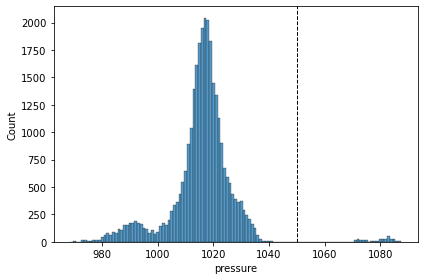

In [6]:
# Show histogram of pressure
sns.histplot(data=df["pressure"], discrete=True)
plt.axvline(1050, c="black", linestyle="dashed",linewidth=1)
plt.tight_layout()

In [7]:
# TODO Remove outliers from the data set
df_filtered =df[df["pressure"]<=1050]
df_filtered =df_filtered[df_filtered["wind_speed"]<=30]

In [8]:
# Test code
assert 'df_filtered' in locals(), "Variable df_filtered is not defined"
assert (df_filtered["pressure"] <= 1050).all(), "contains pressure > 1050"
assert (df_filtered["wind_speed"] <= 30).all(), "contains wind_speed > 30"
assert len(df_filtered) == 29731, "Dropped too many rows"
"ok"

'ok'

### c) Additional features

In [9]:
from datetime import datetime

# TODO Introduce day feature
df_filtered.loc[:, "day"] = pd.to_datetime(df_filtered["time"]).dt.dayofyear
# TODO Introduce generation_solar_categorical feature
df_filtered["generation_solar_categorical"] = pd.cut(df_filtered.loc[:, "generation_solar"], [0, 160, 1600, 100000], labels=["low","medium","high"],right=False)

In [10]:
# Test code
assert all(df_filtered.loc[df_filtered["time"] == "2015-03-02 21:00:00", "day"] == 61)
assert all(df_filtered.loc[df_filtered["time"] == "2018-08-06 11:00:00", "day"] == 218)

assert all(df_filtered["generation_solar_categorical"][df_filtered["generation_solar"] < 160] == "low"), "low label not correct"
assert all(df_filtered["generation_solar_categorical"][(160 <= df_filtered["generation_solar"]) & (df_filtered["generation_solar"] < 1600)] == "medium"), "medium label not correct"
assert all(df_filtered["generation_solar_categorical"][1600 <= df_filtered["generation_solar"]] == "high"), "high label not correct"
"ok"

'ok'

### d) Normalize Data

In [11]:
from sklearn.preprocessing import StandardScaler

# TODO Standardize the dataset
Scaler=StandardScaler(with_mean=True, with_std=True)
df_filtered[["temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all", "generation_solar", "day"]] = Scaler.fit_transform(df_filtered[["temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all", "generation_solar", "day"]])


In [12]:
# Test code
assert "time" in df_filtered.columns
assert "generation_solar_categorical" in df_filtered.columns

for f in ["temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all", "generation_solar", "day"]:
    assert np.isclose(np.mean(df_filtered[f]), 0), f"{f} is not standardized"
    assert np.isclose(np.std(df_filtered[f]), 1), f"{f} is not standardized"

"ok"

'ok'

### e) Train/Validation split

In [28]:
# TODO Train-validation split
# df_train = df_filtered.sample(frac=0.9) # Fails the assert test

df_train = df_filtered.sample(n=26757)
df_val = df_filtered.drop(df_train.index)

In [30]:
# Test code
assert len(df_train) == 26757, "df_train has wrong size"
assert len(df_val) == 2974, "df_test has wrong size"
assert not df_val.index.isin(df_train.index).any(), "df_test and df_train not disjunct"
assert not df_train.index.isin(df_val.index).any(), "df_test and df_train not disjunct"

# Export data sets
df_train.to_csv("solution/b1e-train.csv", index=False)
df_val.to_csv("solution/b1e-val.csv", index=False)

"ok"

'ok'

## Question B2 - Modelling with scikit-learn

### a) Linear regression

In [23]:
from sklearn.linear_model import LinearRegression

predictors = ["day", "temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all"]
target = "generation_solar"

# ********************
# TODO Fit linear model
model = LinearRegression().fit(df_train[predictors],df_train[target])

MSE linear: 0.6356094870696039


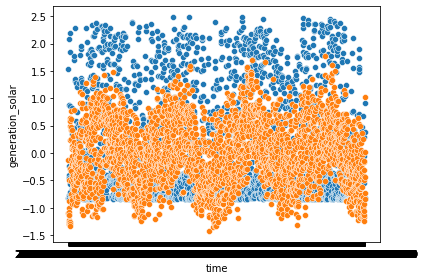

In [24]:
# Test Code
assert "model" in locals(), "Model not implemented"
assert model.coef_.shape == (8, ), "Wrong number of predictors"
_pred = model.predict(df_val[predictors])
sns.scatterplot(x=df_val["time"], y=df_val[target])
sns.scatterplot(x=df_val["time"], y=_pred)
plt.tight_layout()
plt.savefig("solution/b2a.png")
mse = np.mean((_pred - df_val[target])**2)
print(f"MSE linear: {mse}")

### b) Linear regression with non-linear basis functions

In [32]:
from sklearn.preprocessing import PolynomialFeatures

# TODO Create polynomial feature transformation
for n in range(2,6):
    poly = PolynomialFeatures(n)
    # TODO Fit linear model
    model_poly = LinearRegression().fit(poly.fit_transform(df_train[predictors]), df_train[target])
    _pred = model_poly.predict(poly.transform(df_val[predictors]))
    mse = np.mean((_pred - df_val[target])**2)
    print(f"MSE poly degree {n}: {mse}")

# Best poly degree 4 -> in provided solution 2 ?
poly = PolynomialFeatures(4)
model_poly = LinearRegression().fit(poly.fit_transform(df_train[predictors]), df_train[target])

MSE poly degree 2: 0.6119517466319551
MSE poly degree 3: 0.5655749888071122
MSE poly degree 4: 0.5339507854172092
MSE poly degree 5: 0.8334131932677605


MSE poly: 0.5339507854172092


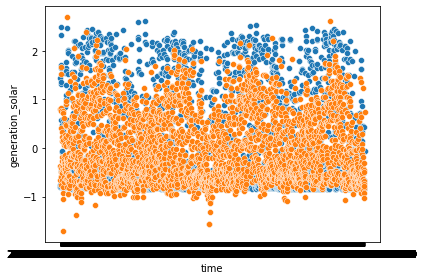

In [33]:
# Test Code
assert "model_poly" in locals(), "model_poly not implemented"
_pred = model_poly.predict(poly.transform(df_val[predictors]))
sns.scatterplot(x=df_val["time"], y=df_val[target])
sns.scatterplot(x=df_val["time"], y=_pred)
plt.tight_layout()
plt.savefig("solution/b2b.png")
mse = np.mean((_pred - df_val[target])**2)
print(f"MSE poly: {mse}")

### c) Classification

In [34]:
from sklearn.linear_model import RidgeClassifier

target = "generation_solar_categorical"

# TODO Fit classifier
model_cls = RidgeClassifier().fit(df_train[predictors],df_train[target])

In [35]:
# Test Code
assert "model_cls" in locals(), "model_cls not implemented"
from sklearn.metrics import classification_report
print(classification_report(df_val[target], model_cls.predict(df_val[predictors]), digits=4))

              precision    recall  f1-score   support

        high     0.5847    0.8124    0.6800       981
         low     0.5318    0.6799    0.5968       959
      medium     0.5221    0.1944    0.2833      1034

    accuracy                         0.5548      2974
   macro avg     0.5462    0.5622    0.5200      2974
weighted avg     0.5459    0.5548    0.5153      2974



## Question B3 - Modelling with PyTorch

In [36]:
# Build data loaders for PyTorch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

predictors = ["day", "temperature", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "clouds_all"]

x_train = torch.tensor(df_train[predictors].values,  dtype=torch.float)
x_val = torch.tensor(df_val[predictors].values,  dtype=torch.float)

y_train = torch.tensor(df_train[["generation_solar"]].values,  dtype=torch.float)
y_val = torch.tensor(df_val[["generation_solar"]].values,  dtype=torch.float)


y_train_cat = torch.tensor(df_train["generation_solar_categorical"].cat.codes.values.copy(),  dtype=torch.int64)
y_val_cat = torch.tensor(df_val["generation_solar_categorical"].cat.codes.values.copy(),  dtype=torch.int64)

# For regression
dataset = TensorDataset(x_train, y_train)

# For classification
dataset_cat = TensorDataset(x_train, y_train_cat)

### a) Build a network

In [37]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # TODO Create layers
        self.input = nn.Linear(8,10)
        self.hdl = nn.Linear(10,10)
        self.output = nn.Linear(10,1)
    
    def forward(self, x):
        # TODO Implement forward pass
        x = F.relu(self.input(x))
        x = F.relu(self.hdl(x))
        x = self.output(x)
        return x

net = Net()

In [38]:
# Test code
np.testing.assert_array_equal([p.nelement() for p in net.parameters()], [80, 10, 100, 10, 10, 1])
np.testing.assert_array_equal(net(torch.zeros(32, 8)).shape, [32, 1])
"ok"

'ok'

### b) Regression

MSE 0.46/0.50: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


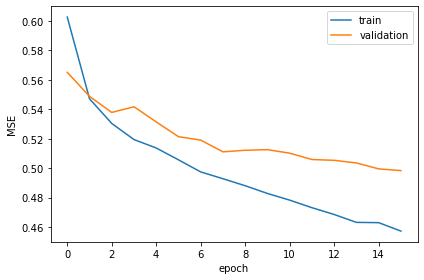

In [40]:
# TODO: Tune typerparameters 
# Hyperparameters
learn_rate = 5e-4
epochs = 16
batch_size = 100

class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        # TODO Create layers
 
        self.drop_layer = nn.AlphaDropout(p=0)
        self.batchnorm = nn.BatchNorm1d(128)
        
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)
 
    def forward(self, x):
        # TODO Implement forward pass
        m = nn.LeakyReLU()
        
        x = m(self.fc1(x))
        x = m(self.fc2(x))
        x = m(self.fc3(x))
        
        x = self.batchnorm(x)        
        x = self.drop_layer(x)
        
        x = m(self.fc4(x))
        x = m(self.fc5(x))
        x = self.fc6(x)
        
        return x
net = Net()

criterion = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=learn_rate)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item() * inputs.shape[0]
        losses.append([running_loss / len(dataset), criterion(net(x_val), y_val).item()])
        pbar.set_description(f"MSE {losses[-1][0]:.02f}/{losses[-1][1]:.02f}")

# Save model
with open("solution/b3b.pt", "wb") as f:
    torch.save(net, f)

# Plot loss
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label="train")
plt.plot(np.arange(len(losses)), losses[:,1], label="validation")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b3b.png")

### c) Classification

Accuracy 0.66/0.63: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]


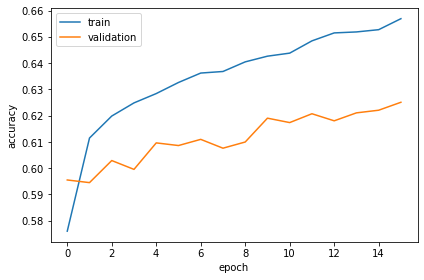

In [41]:
# TODO: Tune typerparameters 
# Hyperparameters
learn_rate = 5e-4
epochs = 16
batch_size = 128

class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        # TODO Create layers
 
        self.drop_layer = nn.AlphaDropout(p=0)
        self.batchnorm = nn.BatchNorm1d(128)
        
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 3)
 
    def forward(self, x):
        # TODO Implement forward pass
        m = nn.LeakyReLU()
        
        x = m(self.fc1(x))
        x = m(self.fc2(x))
        x = m(self.fc3(x))
        
        x = self.batchnorm(x)
        x = self.drop_layer(x)
        
        x = m(self.fc4(x))
        x = m(self.fc5(x))
        x = self.fc6(x)
        
        return x
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=learn_rate)
dataloader_cat = DataLoader(dataset_cat, batch_size=batch_size, shuffle=True)

losses=[]
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader_cat):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += torch.sum((torch.argmax(outputs, dim=1) == labels))  # changed 2021-01-08: Fixed accuracy computation
        losses.append([running_loss / len(dataset_cat), torch.sum((torch.argmax(net(x_val), dim=1) == y_val_cat)) / len(x_val)])  # changed 2021-01-08: Fixed accuracy computation
        pbar.set_description(f"Accuracy {losses[-1][0]:.02f}/{losses[-1][1]:.02f}")

# Save model
with open("solution/b3c.pt", "wb") as f:
    torch.save(net, f)

# Plot loss
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label="train")
plt.plot(np.arange(len(losses)), losses[:,1], label="validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b3c.png")

### d) Evaluation

Which model do you think is suited the best for modelling `generation_solar` and why? Please write down your answer below.

In regard to the MSE the Neural Network had a better result. Although the polynomial function has some values, that are far out of the range and therefore maybe increase the MSE unnecessarily. Therefore further investigation could be done.